In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from hyperopt import hp
from hyperopt import Trials

from lightgbm import LGBMClassifier, early_stopping

from shap import TreeExplainer
from shaphypetune import BoostSearch

import warnings
warnings.simplefilter('ignore')

In [3]:
### CREATE SYNTHETIC DATA ### 

n_feat = 20
n_informative_feat = 8
n_redundant_feat = 5

assert n_feat > 0
assert n_informative_feat > 0
assert n_redundant_feat > 0
assert n_feat > (n_informative_feat + n_redundant_feat + 1)

X, y = make_classification(n_samples=12_000, n_features=n_feat, 
                           n_informative=n_informative_feat, n_redundant=n_redundant_feat,
                           n_classes=2, weights=[0.7, 0.3], class_sep=0.5, 
                           random_state=33, shuffle=False)

informartive_feat = range(0, n_informative_feat)
redundant_feat = range(informartive_feat[-1]+1, informartive_feat[-1] + n_redundant_feat)
noise_feat = range(redundant_feat[-1]+1, n_feat)

X = pd.DataFrame(
    X, columns= \
    [f"feat_{c}_info" for c in informartive_feat] + \
    [f"feat_{c}_combi" for c in redundant_feat] + \
    [f"feat_{c}_noise" for c in noise_feat] 
)

X.shape, y.shape

((12000, 20), (12000,))

<AxesSubplot:ylabel='Density'>

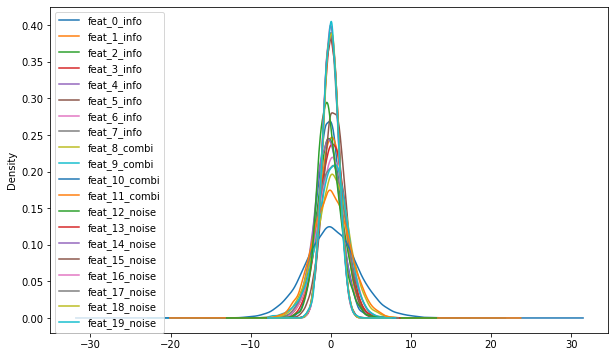

In [4]:
### PLOT FEATURE DISTRIBUTIONS ###

X.plot.density(figsize=(10,6))

In [5]:
### INITIALIZE PARAMETERS ###

param_dist_hyperopt = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'subsample': hp.uniform('gdbt_subsample', 0.5, 1),
    'num_leaves': 5 + hp.randint('num_leaves', 60),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'feature_fraction': hp.uniform('feature_fraction', 0.6, 1.0)
}

def F1(y_true, y_hat):
    return 'f1', f1_score(y_true, np.round(y_hat)), True

q_drifts = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
CV = TimeSeriesSplit(n_splits=5, test_size=800)
lgbm = LGBMClassifier(n_estimators=200, random_state=33, n_jobs=-1)

In [6]:
### DEFINE KOLMOGOROV-SMIRNOV DRIFT DETECTION FUNCTION ###

def ks_drift_detection(X1,X2, n_splits=5, random_state=33):
    
    import numpy as np
    import pandas as pd
    from scipy.stats import ks_2samp
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import StratifiedKFold
    
    assert isinstance(X1,pd.DataFrame)
    assert isinstance(X2,pd.DataFrame)
    
    CV = StratifiedKFold(n_splits, shuffle=True, random_state=random_state)
    y = np.r_[np.ones((X1.shape[0],)),np.zeros((X2.shape[0],))]
    pred = np.zeros_like(y)
    X = pd.concat([X1, X2], ignore_index=True, axis=0)
    
    for i,(id_train,id_test) in enumerate(CV.split(X,y)):
        
        model = LogisticRegression(random_state=random_state)
        model.fit(X.iloc[id_train], y[id_train])
        
        pred[id_test] = model.predict_proba(X.iloc[id_test])[:,1] 

    ks = ks_2samp(pred[(y == 0)], pred[(y == 1)])
    
    return round(ks.statistic, 4), round(ks.pvalue, 4)

In [7]:
### SIMULATE DRIFTS ON RAW DATA DISTRIBUTIONS ###

scores = {}

for i,(id_train,id_test) in enumerate(CV.split(X)):
    for f in X.columns:
        drift_scores = {}
        for q in q_drifts:
            cond = X.iloc[id_test][f] < X.iloc[id_test][f].quantile(q)
            drift_scores[q] = ks_drift_detection(
                X.iloc[id_train], X.iloc[id_test][cond]
            )[0]
            cond = X.iloc[id_test][f] > X.iloc[id_test][f].quantile(1-q)
            drift_scores[1-q] = ks_drift_detection(
                X.iloc[id_train], X.iloc[id_test][cond]
            )[0]
        scores[(f"split_{i+1}",f)] = drift_scores
    
scores = pd.DataFrame(scores).T.groupby(level=1).mean().T[X.columns]

Text(0, 0.5, 'KS statistic')

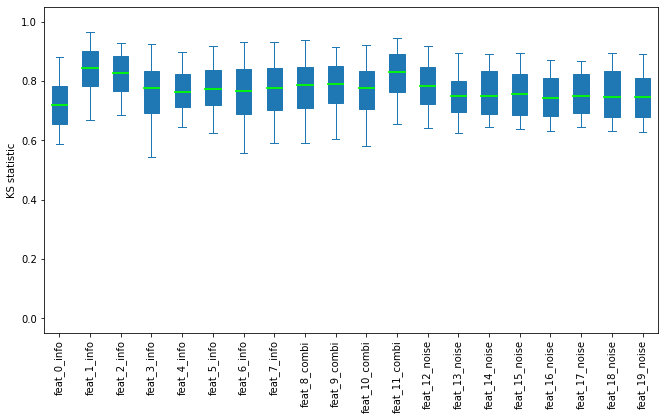

In [8]:
### PLOT TEST DRIFT RESULTS ###

scores.plot.box(
    rot=90, figsize=(11,6), 
    medianprops=dict(linestyle='-', linewidth=1.8, c='lime'), 
    patch_artist=True
)
plt.ylim([-0.05,1.05]); plt.ylabel('KS statistic')

In [9]:
### SIMULATE DRIFTS ON SHAP DATA DISTRIBUTIONS ###

scores_shap = {}
shap_importances = np.zeros((n_feat,))


for i,(id_train,id_test) in enumerate(CV.split(X)):
    
    print()
    print("#"*22)
    print("#"*7, f"FOLD {i+1}", "#"*7)
    print("#"*22)
    
    X_train = X.iloc[id_train]
    y_train = y[id_train]
    X_test = X.iloc[id_test]
    y_test = y[id_test]
    
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, shuffle=True, test_size=0.2, random_state=33
    )
    
    model = BoostSearch(
        lgbm, 
        param_grid=param_dist_hyperopt, 
        greater_is_better=True, 
        n_iter=30, sampling_seed=33
    )
    model.fit(
        X_train, y_train, 
        trials=Trials(), 
        eval_set=[(X_val, y_val)], 
        callbacks=[early_stopping(5, verbose=False)], eval_metric=F1
    )
    
    explainer = TreeExplainer(
        model.estimator_, 
        feature_perturbation="tree_path_dependent"
    )
    X_train_shap = explainer.shap_values(X_train)[0]
    X_train_shap = pd.DataFrame(X_train_shap, index=X_train.index)
    X_train_shap.columns = [f"{c}_shap" for c in X.columns]
    X_val_shap = explainer.shap_values(X_val)[0]
    X_val_shap = pd.DataFrame(X_val_shap, index=X_val.index)
    X_val_shap.columns = [f"{c}_shap" for c in X.columns]
    X_test_shap = explainer.shap_values(X_test)[0]
    X_test_shap = pd.DataFrame(X_test_shap, index=X_test.index)
    X_test_shap.columns = [f"{c}_shap" for c in X.columns]
    shap_importances += np.asarray(np.abs(X_val_shap).mean(0))
    
    for f in X.columns:
        drift_scores = {}
        for q in q_drifts:
            cond = X_test[f] < X_test[f].quantile(q)
            drift_scores[q] = ks_drift_detection(
                X_train_shap, X_test_shap[cond]
            )[0]
            cond = X_test[f] > X_test[f].quantile(1-q)
            drift_scores[1-q] = ks_drift_detection(
                X_train_shap, X_test_shap[cond]
            )[0]
        scores_shap[(f"split_{i+1}",f)] = drift_scores

shap_importances = pd.Series(shap_importances / CV.n_splits, index=X_val_shap.columns)
shap_importances = (shap_importances - shap_importances.min()) /\
                    (shap_importances.max()-shap_importances.min())
scores_shap = pd.DataFrame(scores_shap).T.groupby(level=1).mean().T[X.columns]


######################
####### FOLD 1 #######
######################

30 trials detected for ('class_weight', 'subsample', 'num_leaves', 'learning_rate', 'reg_alpha', 'reg_lambda', 'feature_fraction')

trial: 0001 ### iterations: 00001 ### eval_score: 0.0
trial: 0002 ### iterations: 00001 ### eval_score: 0.0
trial: 0003 ### iterations: 00042 ### eval_score: 0.88917
trial: 0004 ### iterations: 00042 ### eval_score: 0.88917
trial: 0005 ### iterations: 00042 ### eval_score: 0.88917
trial: 0006 ### iterations: 00042 ### eval_score: 0.88917
trial: 0007 ### iterations: 00042 ### eval_score: 0.88917
trial: 0008 ### iterations: 00024 ### eval_score: 0.90095
trial: 0009 ### iterations: 00024 ### eval_score: 0.90095
trial: 0010 ### iterations: 00024 ### eval_score: 0.90095
trial: 0011 ### iterations: 00024 ### eval_score: 0.90095
trial: 0012 ### iterations: 00024 ### eval_score: 0.90095
trial: 0013 ### iterations: 00024 ### eval_score: 0.90095
trial: 0014 ### iterations: 00024 ### eval_score: 0

<AxesSubplot:title={'center':'SHAP Feature Importances'}>

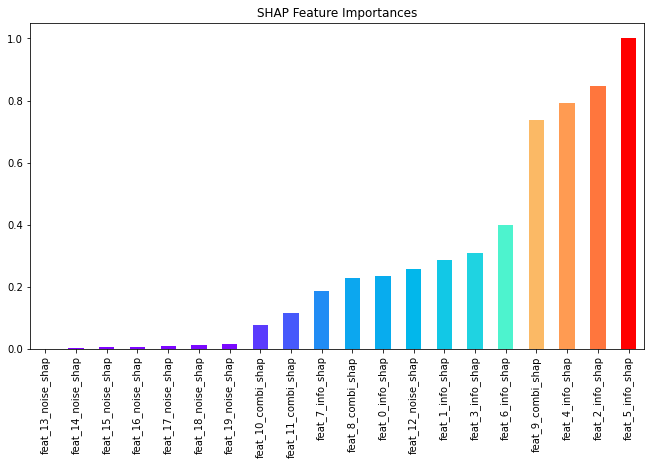

In [10]:
### PLOT SHAP FEATURE IMPORTANCES ###

cm = plt.cm.get_cmap('rainbow')
colors_cm = [cm(s_imp) for s_imp in shap_importances.sort_values()]

shap_importances.sort_values().plot.bar(figsize=(11,6), color=colors_cm, title='SHAP Feature Importances')

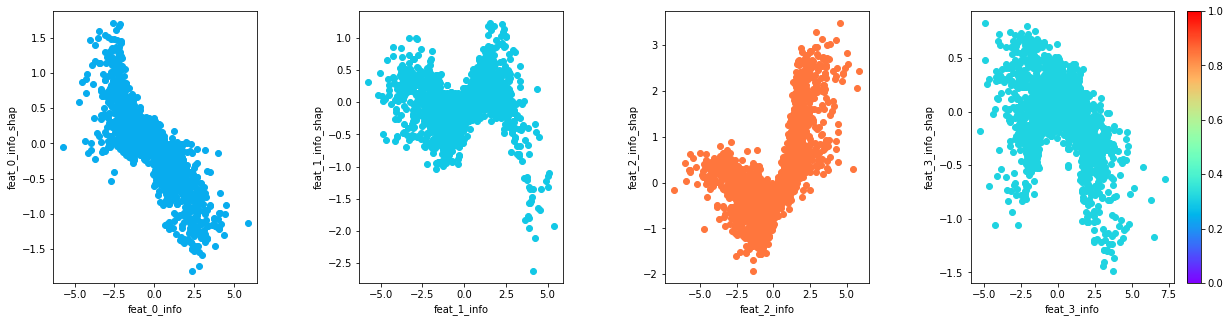

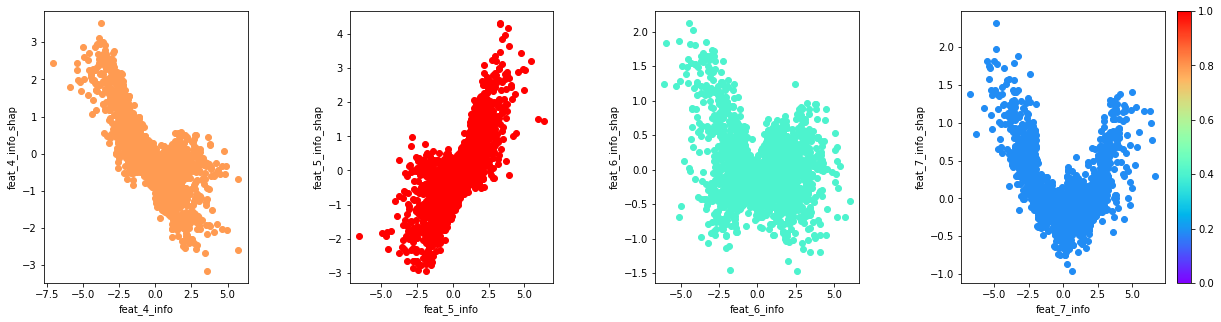

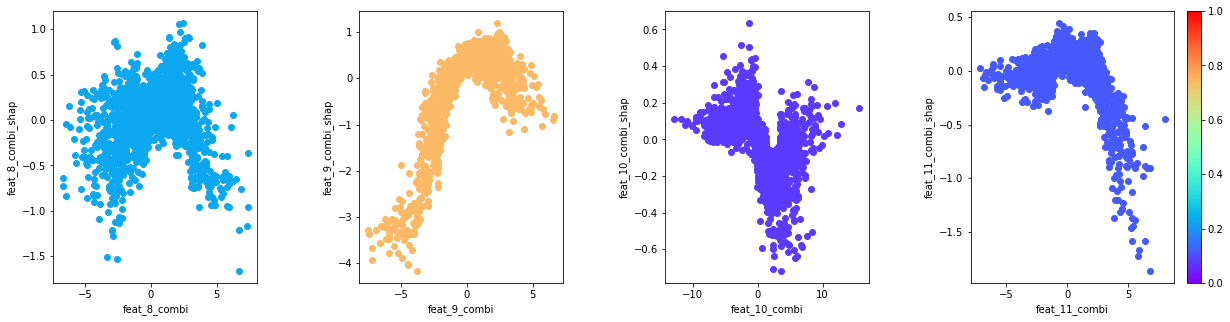

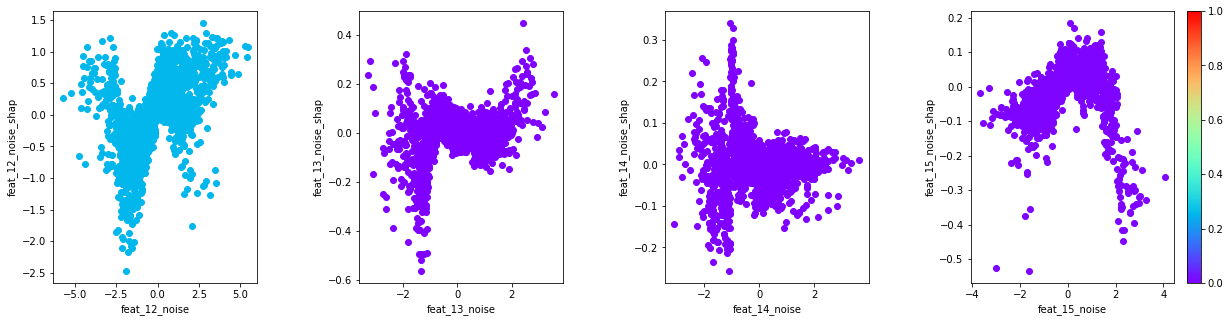

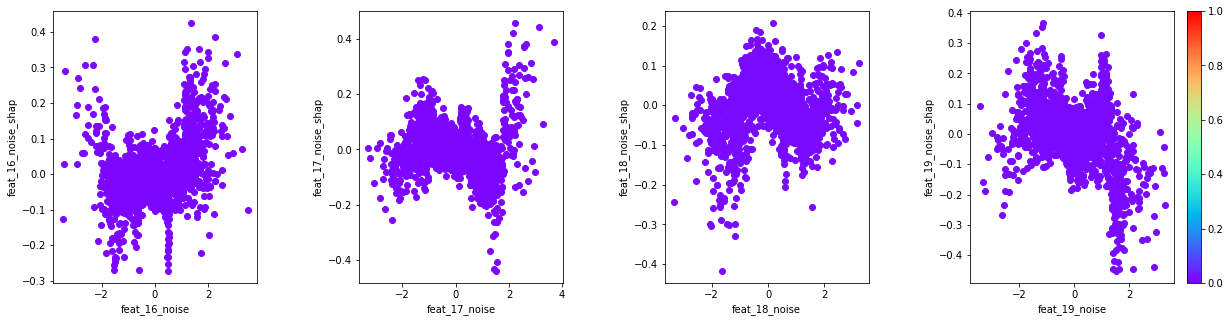

In [11]:
### PLOT SHAP DISTRIBUTIONS vs REAL DATA DISTRIBUTIONS ###

cm = plt.cm.get_cmap('rainbow')
colors_cm = [cm(s_imp) for s_imp in shap_importances]

for i,(c_shap,c) in enumerate(zip(X_val_shap, X_val)):
    if i%4 == 0:
        fig = plt.figure(figsize=(21,5))
    ax = plt.subplot(1,4,(i%4)+1)
    ax.scatter(X_val[c], X_val_shap[c_shap], color=colors_cm[i])
    plt.xlabel(c); plt.ylabel(c_shap)
    cb = fig.colorbar(plt.cm.ScalarMappable(
        plt.cm.colors.Normalize(shap_importances.min(),shap_importances.max()), 
        cmap='rainbow'
    ), ax=ax, cmap='rainbow')
    if i%4 == 3:
        plt.show()
    else:
        cb.remove()

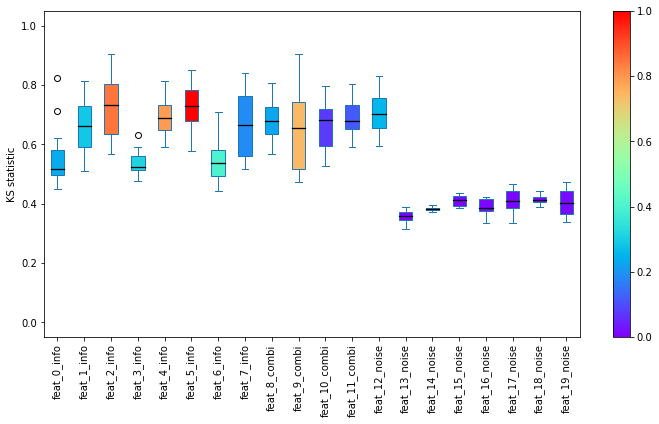

In [12]:
### PLOT TEST DRIFT RESULTS ###

fig,ax = plt.subplots(figsize=(12,6))
ax,props = scores_shap.plot.box(
    rot=90, medianprops=dict(linestyle='-', linewidth=1.3, c='black'),
    ax=ax, patch_artist=True, return_type='both'
)
for patch, color in zip(props['boxes'], colors_cm):
    patch.set_facecolor(color)
fig.colorbar(plt.cm.ScalarMappable(
    plt.cm.colors.Normalize(shap_importances.min(),shap_importances.max()), 
    cmap='rainbow'
), ax=ax, cmap='rainbow')
plt.ylim([-0.05,1.05]); plt.ylabel('KS statistic')
plt.show()